# LLM Data Cleansing Pipeline

#### Loading Environment Variables and Initialize API Key

In [1]:
from dotenv import load_dotenv
import os

# loading .env file
load_dotenv()

# setting OPENAI_API_KEY
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

#### Initialize LLM

In [2]:
import openai
from langchain_openai import ChatOpenAI


# Setting model
llm_model = "gpt-4o-mini" 

# Initialize OpenAI LLM with LangChain
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name=llm_model,
    temperature=0,   # Control randomness: 0.0 is deterministic, 1.0 is very creative
    #max_tokens=1500    # Max tokens in the response
)

#### Initialize Prompt

In [3]:
# Load prompt from prompt.txt file
with open('prompt.txt', 'r') as file:
    prompt = file.read()

print('\nPreview Prompt:\n')
print(prompt)


Preview Prompt:

You are tasked with converting the following durations to days. These durations are a free-form text field on an 811 
OneCall Ticket. The Duration is how long the job should last. There may be misspellings or errors. If you see an 
estimate or range, use the highest value. The minimum number of days if duration is known should be 1; if something is 
1 hour, it should be 1 day. Anything that cannot convert to a day is an error (set "days" to 0). For full days, enter 
the exact number of days. For any part of a day mentioned (like hours or half days), count each as a full day if the 
activity spans multiple days, reflecting the occupation of each calendar day.  If the duration is not known, it should
be 0 and an estimate.

First column, "duration", will be the original value (leave it exactly as it was entered).

Second column, "days", will be the standardized amount in days (integer only).

Third column, "is_estimate", will be binary (1 for yes, 0 for no). This is used

#### Initialize Data

Loading <code>llm_unique_data.csv</code>, which has duplicate values removed to save on unnecessary computational costs.

In [4]:
import pandas as pd
import tiktoken

# Load the CSV data and assign to DataFrame
csv_file_path = 'data/llm_unique_data.csv'
raw_df = pd.read_csv(csv_file_path)

# Setting the DURATION column to llm_data
llm_data = raw_df['DURATION']

# Display the first few data entries
print("Raw Data Preview:")
display(llm_data.head())

Raw Data Preview:
Raw Data Preview:


0    NOT APPLICABLE
1           14 DAYS
2             1 DAY
3            5 DAYS
4           2 WEEKS
Name: DURATION, dtype: object

#### Preprocess Data - LLM Input

In [5]:
import pandas as pd
import string
import re

# Define a function to preprocess each duration entry
def preprocess_duration(text):
    if pd.isna(text):
        return ""  # for blank row
    
    # Convert to string (in case it's not)
    text = str(text)
    
    # Trim leading and trailing whitespace
    text = text.strip()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation using str.translate
    #text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove any non-printable characters
    #text = ''.join(char for char in text if char.isprintable())
    
    # Normalize whitespace (replace multiple spaces with single space)
    text = re.sub(r'\s+', ' ', text)
    
    # Enclose the cleaned text in double quotes
    text = f'"{text}"'
    
    return text

# Apply the preprocessing function to llm_data
llm_data = llm_data.apply(preprocess_duration)

# Display the first few preprocessed entries
print("Preprocessed Data Preview:")
display(llm_data.head())

Preprocessed Data Preview:
Preprocessed Data Preview:


0    "not applicable"
1           "14 days"
2             "1 day"
3            "5 days"
4           "2 weeks"
Name: DURATION, dtype: object

#### Estimate Total Tokens to Send
Using tiktoken to determin total tokens to be sent.

In [6]:
# Initialize tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")

# Tokenize each entry in the DURATION column and count tokens
llm_data_tokens = llm_data.apply(lambda x: len(tokenizer.encode(str(x))))

# Calculate the total number of tokens
total_tokens = llm_data_tokens.sum()

# Checking output 
print(f'\nTotal Rows: {len(llm_data)}')
print(f'Total Tokens: {total_tokens}')


Total Rows: 1356
Total Tokens: 7102


Total Rows: 1356
Total Tokens: 7102


#### Define Function to Batch <code>llm_data</code> Based on Tokens

In [7]:
import tiktoken

max_tokens = 3000

def split_data_by_token_limit(data, prompt, max_tokens=max_tokens):

    """Splits data into batches that stay within the token limit."""
    
    current_batch = []
    prompt_tokens = len(tokenizer.encode(prompt))  # Get the token count for the prompt
    current_tokens = prompt_tokens  # Start the token count for the batch with the prompt tokens
    
    for row in data:
        row = str(row)  # Ensure that the row is treated as a string
        row_tokens = len(tokenizer.encode(row))
        
        # Check if adding the current row would exceed the max_tokens limit
        if current_tokens + row_tokens > max_tokens:
            yield current_batch  # Return the current batch when max_tokens is reached
            current_batch = []  # Start a new batch
            current_tokens = prompt_tokens  # Reset token count with the prompt tokens included for the new batch
        
        current_batch.append(row)
        current_tokens += row_tokens  # Add the row's token count to the current batch
    
    if current_batch:  # Yield the last batch if there's any data left
        yield current_batch

#### Process Each Batch

*** eventually want to make role more specific ***

In [8]:
# Initialize the list to store results
results = []

# Loop through each batch
for batch in split_data_by_token_limit(llm_data, prompt):
    # Prepare the data from the current batch
    batch_text = ', '.join(batch)
    
    # Combine the prompt and batch data into a single message format
    messages = [
        {"role": "user", "content": f"{prompt}\nData: {batch_text}"}
    ]

    # Call the LLM using the .invoke() method
    try:
        response = llm.invoke(messages)
        
        # Extract the content (the results returned by the LLM)
        content = response.content
        
        # Append the content to the results list
        results.append(content)
    
    except Exception as e:
        print(f"Error processing batch: {e}")

#### Convert Responses to DataFrame

*** add preprocessing steps to avoid having to skip bad lines ***

In [9]:
import pandas as pd
import io

# Initialize an empty list to store DataFrames
df_list = []

# Process each CSV string in results
for content in results:
    try:
        # Read the CSV-formatted string into a DataFrame
        df = pd.read_csv(io.StringIO(content))#, on_bad_lines='skip')
        df_list.append(df)
    
    except Exception as e:
        print(f"Error parsing result: {e}")


# Concatenate all DataFrames if any
if df_list:
    df_results = pd.concat(df_list, ignore_index=True)
    display(df_results)

else:
    print("No valid results to convert into a DataFrame.")

,duration,days,is_estimate
0,not applicable,0,1
1,14 days,14,0
2,1 day,1,0
3,5 days,5,0
4,2 weeks,14,0
...,...,...,...
1351,march 27-may 27,62,0
1352,water line repa,0,1
1353,one day/4 hours,1,1
1354,april 5-7. stor,3,0


#### Comparing to Labels

Days Accuracy: 87.54% (1187 out of 1356 correct)
Estimate Accuracy: 69.10% (937 out of 1356 correct)

Sample Days Mismatches:
          duration  days  DAYS_original
17            week     0              7
29     spring 2025     0             93
51   2weeks to 1 m    14             30
67            none     0              1
75   several weeks    14              0
108         1 weel     0              7
137      12 months   365            360
148       few days     2              0
154         1 dasy     0              1
166      few weeks    14              0

Sample Estimate Mismatches:
       duration  is_estimate  ESTIMATE_original
17         week            1                  0
23    2 hour(s)            1                  0
27    1 hour(s)            1                  0
28   24 hour(s)            1                  0
29  spring 2025            1                  0
40      2 hours            1                  0
47    5 hour(s)            1                  0
52      1-2 hrs      

<positron-console-cell-13>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<positron-console-cell-13>:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<positron-console-cell-13>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

<positron-console-cell-13>:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


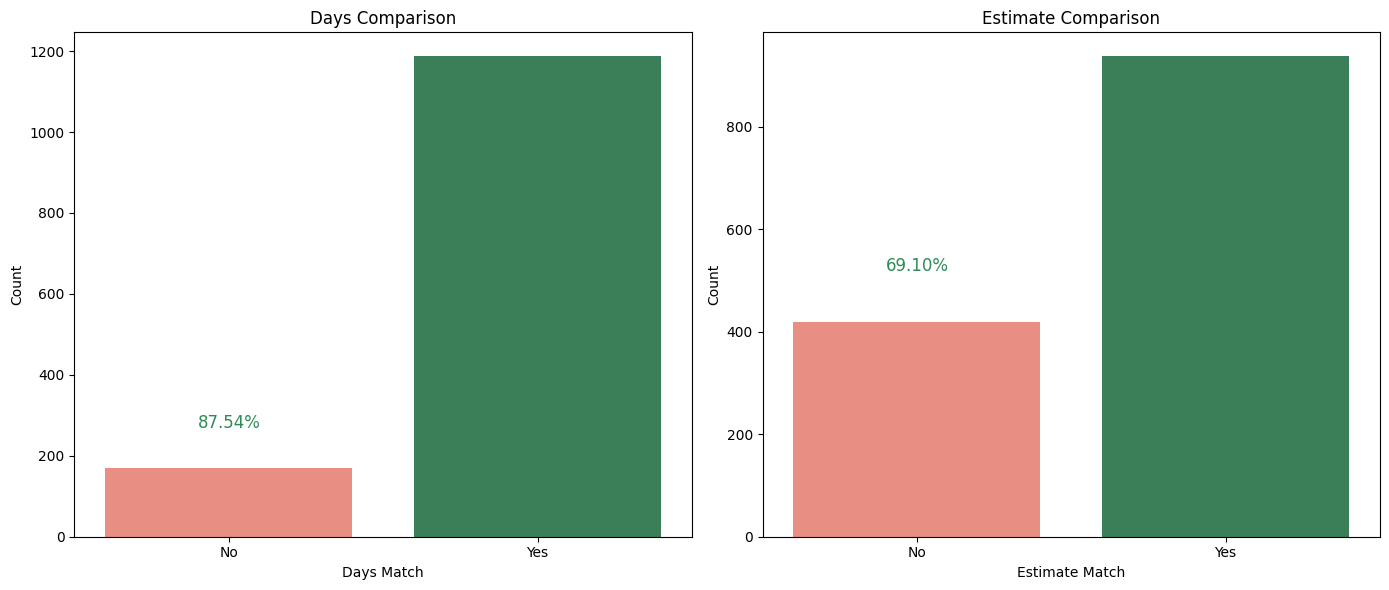

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that raw_df and df_results have been previously defined and contain the necessary columns
# raw_df should have 'DAYS' and 'ESTIMATE' columns
# df_results should have 'days' and 'is_estimate' columns

# 1. Verify Row Counts
if len(raw_df) != len(df_results):
    raise ValueError(f"Row count mismatch: raw_df has {len(raw_df)} rows, df_results has {len(df_results)} rows.")

# 2. Reset Index to Ensure Alignment
raw_df = raw_df.reset_index(drop=True)
df_results = df_results.reset_index(drop=True)

# 3. Check if 'DAYS' and 'ESTIMATE' Columns Exist in raw_df
required_columns = ['DAYS', 'ESTIMATE']
missing_columns = [col for col in required_columns if col not in raw_df.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing in raw_df: {missing_columns}")

# 4. Add Original Columns to df_results for Comparison
df_results['DAYS_original'] = raw_df['DAYS']
df_results['ESTIMATE_original'] = raw_df['ESTIMATE']

# 5. Compare 'days' with 'DAYS_original'
df_results['days_match'] = df_results['days'] == df_results['DAYS_original']
days_accuracy = df_results['days_match'].mean() * 100
print(f"Days Accuracy: {days_accuracy:.2f}% ({df_results['days_match'].sum()} out of {len(df_results)} correct)")

# 6. Compare 'is_estimate' with 'ESTIMATE_original'
df_results['estimate_match'] = df_results['is_estimate'] == df_results['ESTIMATE_original']
estimate_accuracy = df_results['estimate_match'].mean() * 100
print(f"Estimate Accuracy: {estimate_accuracy:.2f}% ({df_results['estimate_match'].sum()} out of {len(df_results)} correct)")

# 7. Display Sample Mismatches for 'days'
days_mismatches = df_results[df_results['days_match'] == False]
print("\nSample Days Mismatches:")
print(days_mismatches[['duration', 'days', 'DAYS_original']].head(10))

# 8. Display Sample Mismatches for 'is_estimate'
estimate_mismatches = df_results[df_results['estimate_match'] == False]
print("\nSample Estimate Mismatches:")
print(estimate_mismatches[['duration', 'is_estimate', 'ESTIMATE_original']].head(10))

# 9. Visualize the Comparison Results
plt.figure(figsize=(14, 6))

# Subplot for Days Comparison
plt.subplot(1, 2, 1)
sns.countplot(x='days_match', data=df_results, palette=['salmon', 'seagreen'])
plt.title('Days Comparison')
plt.xlabel('Days Match')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.text(-0.1, df_results['days_match'].value_counts()[1] + 100, f"{days_accuracy:.2f}%", fontsize=12, color='seagreen')

# Subplot for Estimate Comparison
plt.subplot(1, 2, 2)
sns.countplot(x='estimate_match', data=df_results, palette=['salmon', 'seagreen'])
plt.title('Estimate Comparison')
plt.xlabel('Estimate Match')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.text(-0.1, df_results['estimate_match'].value_counts()[1] + 100, f"{estimate_accuracy:.2f}%", fontsize=12, color='seagreen')

plt.tight_layout()
plt.show()


In [11]:
print(len(df_results))
print(len(raw_df))

1356
1356
1356
1356
